## Data Import

In [788]:
import numpy as np
import pandas as pd 

import re
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from wordcloud import WordCloud
import mpld3

import warnings
warnings.simplefilter('ignore')

In [789]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/charlottefeng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [790]:
df = pd.read_excel('landscape_analysis_missions.xlsx')

In [791]:
df.head(5)

,Organization,Mission
0,After School All Stars,"After-School All-Stars provides free, comprehe..."
1,FIRST Robotics Competition,"FIRST LEGO League introduces science, technolo..."
2,Girls Who Code,Girls Who Code is on a mission to close the ge...
3,TechGirlz,TechGirlz is a nonprofit program of Creating I...
4,South Jersey Robotics,Our Vision:\nTransform the culture in South Je...


### About data
- `Mission` is scraped from organization websites in sections of "what we do"/"mission"/"vision".
- Though this is done manually, scrapers can be developed to automate the process.

In [792]:
df.columns = map(str.lower, df.columns)

In [793]:
df.shape

(22, 2)

In [867]:
def plot_wordcloud(df):
    text = df['mission'].str.lower()
    text = ''.join(str(t) for t in text) # string
    
    # pos to keep: adj, adv, n(p)
    pos = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', \
           'NNP', 'NNPS', 'PDT', 'POS',\
           'RB', 'RBR', 'RBS'] 
    tokens = word_tokenize(text)
    tokens_tag = pos_tag(tokens)
    tokens_filtered = [t[0] for t in tokens_tag if t[1] in pos]
    text_filtered = ' '.join(str(t) for t in tokens_filtered)
    
    wordcloud = WordCloud(max_words=100,
                          max_font_size=80, width=1000, height=500,
                          background_color='white').generate(text_filtered)

    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Wordcloud for Missions', fontsize=15)
    plt.savefig('wc_missions.png', dpi=200)
    plt.show()

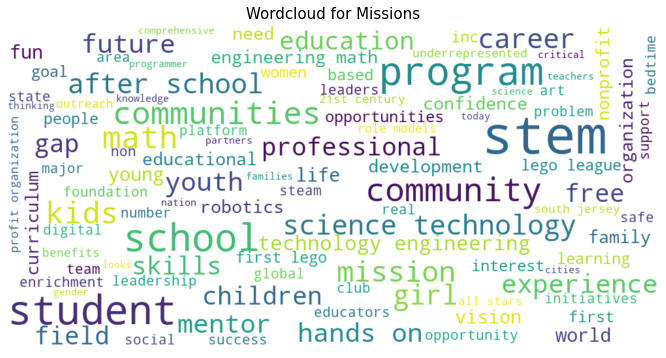

In [868]:
plot_wordcloud(df)

## Preprocessing

### Text Cleaning
- Lowercase
- Remove punctuations, special characters and digits
- For each mission statement, remove the corresponding organization name. Repetitive occurence can affect token frequency later.

In [796]:
def clean_text(df):
    df['text_cleaned'] = df['mission'].str.lower()
    df['text_cleaned'] = df['text_cleaned'].apply(
        lambda x: re.sub(r'[^A-Za-z]+', ' ', x))
    df['text_cleaned'] = [m.replace(o.lower(), ' ') \
                          for o, m in zip(df.organization, df.text_cleaned)]
    return df

In [797]:
df_cleaned = clean_text(df)

In [798]:
df_cleaned[['mission', 'text_cleaned']].head(5)

,mission,text_cleaned
0,"After-School All-Stars provides free, comprehe...",provides free comprehensive after school pro...
1,"FIRST LEGO League introduces science, technolo...",first lego league introduces science technolog...
2,Girls Who Code is on a mission to close the ge...,is on a mission to close the gender gap in t...
3,TechGirlz is a nonprofit program of Creating I...,is a nonprofit program of creating it future...
4,Our Vision:\nTransform the culture in South Je...,our vision transform the culture in south jers...


### TF-IDF

In [799]:
class LemmaTokenizer(object):
    """
    https://scikit-learn.org/stable/modules/feature_extraction.html
    @n: minimum length of a token
    """
    def __init__(self, n):
        self.wnl = WordNetLemmatizer()
        self.n = n
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) \
                for t in word_tokenize(articles)\
                if len(t) >= self.n]

In [800]:
tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(n=2), # >=2 characters
                        stop_words = 'english') # ngram_range=(1, 3)

In [801]:
text_mat = tfidf.fit_transform(df['text_cleaned'])

In [802]:
text_mat.shape

(22, 543)

In [803]:
vocab = tfidf.get_feature_names()

In [804]:
dist = 1 - cosine_similarity(text_mat)

In [869]:
dist.shape

(22, 22)

## K-means Clustering
- Given the small dataset, tuning is not so necessary as larger K will always lead to smaller inertia.

In [805]:
SEED = 42

In [806]:
def fit_kmeans(text_matrix, K=3, tuning=False):
    if tuning:
        K = range(2, 6)
        inertia = [] # Sum of squared distances of samples to their closest cluster center
        for k in K:
            km = KMeans(n_clusters=k,
                        random_state=SEED)
            km = km.fit(text_matrix)
            inertia.append(km.inertia_)
            
        # Elbow method
        plt.plot(K, inertia, 'bx-')
        plt.xlabel('K')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal K')
        plt.show()
        
        K = K[np.argmin(inertia)]
        print(f'Optimal K = {K}')
    
    km = KMeans(n_clusters=K, random_state=SEED)
    km.fit(text_matrix)
    clusters = km.labels_.tolist()
    
    return km, clusters

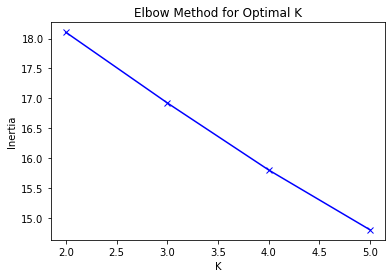

Optimal K = 5


In [807]:
km, clusters = fit_kmeans(text_mat, tuning=True)

In [808]:
df_cleaned['cluster'] = clusters

In [809]:
df_cleaned['cluster'].value_counts()

0    10
2     4
1     4
3     3
4     1
Name: cluster, dtype: int64

In [810]:
# Find out which cluster JerseySTEM belongs to
js_cluster = int(
    df_cleaned.loc[df_cleaned['organization'] == 'JerseySTEM', 'cluster'])

In [811]:
df_cleaned.loc[df_cleaned['cluster'] == js_cluster, 'organization']

5                                    Students 2 Science
9                                           STEMKidsNYC
10            STEM ALLIANCE OF LARCHMONT-MAMARONECK INC
11                                         Digital Girl
14                                             STEM Gen
15                                      Geeks Rule, Inc
16                                           4th Family
17                                   Aviation Influence
18    Schoharie Mohawk Initiative for Science and Te...
21                                           JerseySTEM
Name: organization, dtype: object

In [812]:
def get_cluster_top_words(km, K, n=5, vocab=vocab):
    # Sort words by proximity to cluster centroid
    words_ordered = km.cluster_centers_.argsort()[:,::-1] # Word index
    cluster_words = {}
    
    results = pd.DataFrame(columns=['cluster', 'words'])
    for i in range(K):
        top_n = km.cluster_centers_.argsort()[:,::-1][i,:n]
        top_n_words = ', '.join([vocab[i] for i in top_n]) # String
        cluster_words[i] = top_n_words 
    
    return cluster_words

In [813]:
cluster_words = get_cluster_top_words(km, 5)

In [814]:
cluster_words

{0: 'stem, community, education, youth, opportunity',
 1: 'mentor, lego, league, robotics, steam',
 2: 'school, kid, program, make, math',
 3: 'girl, world, best, scout, creation',
 4: 'change, image, close, doe, programmer'}

In [815]:
df_cleaned['keywords'] = df_cleaned['cluster'].map(cluster_words)

In [816]:
df_cleaned.head(5)

,organization,mission,text_cleaned,cluster,keywords
0,After School All Stars,"After-School All-Stars provides free, comprehe...",provides free comprehensive after school pro...,2,"school, kid, program, make, math"
1,FIRST Robotics Competition,"FIRST LEGO League introduces science, technolo...",first lego league introduces science technolog...,1,"mentor, lego, league, robotics, steam"
2,Girls Who Code,Girls Who Code is on a mission to close the ge...,is on a mission to close the gender gap in t...,4,"change, image, close, doe, programmer"
3,TechGirlz,TechGirlz is a nonprofit program of Creating I...,is a nonprofit program of creating it future...,3,"girl, world, best, scout, creation"
4,South Jersey Robotics,Our Vision:\nTransform the culture in South Je...,our vision transform the culture in south jers...,1,"mentor, lego, league, robotics, steam"


## Visualization: Multidimensional scaling

In [841]:
def plot_cluster(df=df_cleaned, dist=dist, interactive=False):
    # Map dist to 2D-array (i.e., coordinates)
    mds = MDS(dissimilarity='precomputed', 
          random_state=SEED)
    coord = mds.fit_transform(dist)
    df['_x'], df['_y'] = coord[:, 0], coord[:, 1]
    
    # Create a colormap for each cluster
    n_clusters = df.cluster.nunique()
    cmap = cm.get_cmap('Paired', n_clusters)
    df['color'] = df['cluster'].map(cmap)

    fig, ax = plt.subplots(figsize=(15, 8))
    for i in range(len(df)):
        x, y = df.loc[df.index[i], '_x'], df.loc[df.index[i], '_y']
        lab = df.loc[df.index[i], 'keywords']
        clr = df.loc[df.index[i], 'color']
        org = df.loc[df.index[i], 'organization']
        padding = 0.02
        
        ax.plot(x, y, label=lab, color=clr,
                marker='o', linestyle='', ms=15, mec='none')
        
        # Annotate the organizations
        size = 15 if org == 'JerseySTEM' else 10
        color = 'red' if org == 'JerseySTEM' else 'black'
        ax.text(x+padding, y, org, size=size, color=color)  
    
    ax.legend()
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()  
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())
    
    ax.set_aspect('auto')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('cluster.png', dpi=200)
    plt.show()

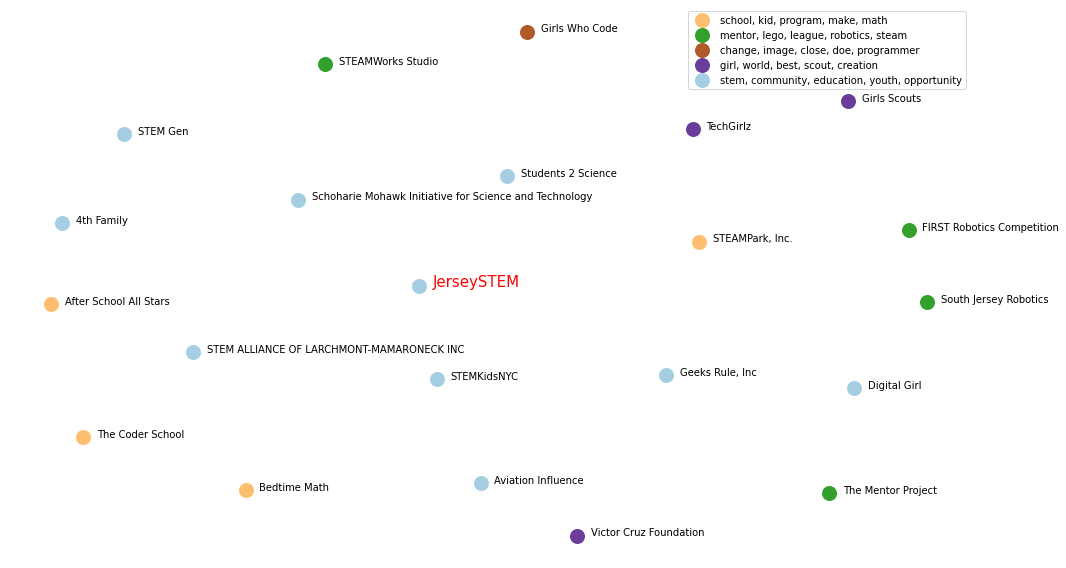

In [842]:
plot_cluster()

**Remarks:**
- Organizations with the same color are of the same cluster so that they share similar missions.
- The distance between each organization shows the difference in missions.
    - Closer organizations are more similar in missions (also higher probability of collaboration/competition?)
- What's more?
    - Topic modeling using LDA
        - To draw insights on content design (workshops, programs)